In [1]:
from scipy import integrate as inte
import numpy as np
import matplotlib.pyplot as plt
from numpy import log as ln
G = 6.674E-11  # m^3 kg^-1 s^-2
Msun = 1.989E30  # kg
import numpy as np
import numpy.ma as ma
from scipy.special import kn
from scipy.special import iv
gamma = 3.3308
kappa = gamma * ln(10)

In [23]:
r = np.linspace(0.01,30,1000)

# de Vaucouleur's Bulge
(Sofue 2013, eqn 27, 29, & 30)

$$\Sigma(r) = \Sigma_{be} (-\kappa (\frac{r}{r_b})^{\frac{1}{4}} - 1)$$

$$\rho(R) = \frac{1}{\pi}\int^{\infty}_R \frac{d\Sigma_b(x)}{dx}\frac{1}{\sqrt{x^2 - R^2}}dx$$

$$M_b(R) = 4\pi\int^{R}_{0} \rho(R') R'^2dR' $$

$$V_b(R) = \sqrt{\frac{GM_b(R)}{R}}$$

In [ ]:
def sigma_b(x, SigBE, Rb):
    return SigBE * np.exp(-1 * kappa * ((x / Rb) ** 0.25 - 1))


# derivative of sigma with respect to r
def dsdx(x, SigBE, Rb):
    return sigma_b(x, SigBE, Rb) * (-0.25 * kappa) * (Rb ** -0.25) * (x ** -0.75)


# integrand for getting denisty
def density_integrand(x, r, SigBE, Rb):
    return -(1 / np.pi) * dsdx(x, SigBE, Rb) / np.sqrt(x ** 2 - r ** 2)


def mass_integrand(r, SigBE, Rb):
    vol_den, vol_den_err = inte.quad(density_integrand, r, np.inf, args=(r, SigBE, Rb))
    return 4 * np.pi * vol_den * r ** 2

def vcir_b(r,SigBE, Rb):
    if isinstance(r, float):
        bulge_mass, m_err = inte.quad(mass_integrand, 0, r, args=(SigBE, Rb))
    else:
        bulge_mass = np.zeros(len(r))
        err = np.zeros(len(r))

        for i in range(len(r)):
            bulge_mass[i],err[i] = inte.quad(mass_integrand, 0, r[i], args=(SigBE, Rb))
    vel = np.sqrt(G*(bulge_mass*Msun)/(r*3.08E16))
    vel /= 1000
    
    return vel

plt.plot(r, vcir_b(r*1000,3.2E3, 0.5E3))
plt.xlabel('$r [kpc]$')
plt.ylabel('$V_{cir}$ [km/s]')
plt.title('MW Bulge [de Vaucouleur]')

# Simplified bulge model 

(Di Paolo et al. 2019 eqn 8)

$$V^2{b}(r) = \alpha_{b} V^2_{in} (\frac{r}{R_{in}})^{-1}$$
$$R_{in} \simeq 0.2 <R_d>$$

In [ ]:
def bulge_vel(r, A, Vin, Rd):
    if isinstance(r, float):
        v = np.sqrt(A * Vin **2 * (r/(0.2*Rd)) ** -1)
    else:
        v = np.zeros(len(r))
        for i in range(len(r)):
            v[i] = np.sqrt(A * Vin **2 * (r[i]/(0.2*Rd)) ** -1)
    return v

In [ ]:
plt.plot(r,bulge_vel(r*1000,0.1,127,3500))
plt.xlabel('$r [kpc]$')
plt.ylabel('$V_{cir}$ [km/s]')
plt.title('MW Bulge [Point Mass]')

This model will have $V_b \rightarrow \infty$ as $r \rightarrow 0$

# Modified bulge model

For $0 < r < R_{in}$:

$$V^2{b}(r) = \frac{\alpha_{b} V^2_{in} r}{R_{in}}$$

For $r \geqslant R_{in}$:

$$V^2{b}(r) = \alpha_{b} V^2_{in} (\frac{r}{R_{in}})^{-1}$$

In [ ]:
def bulge_vel_mod(r, A, Vin, Rd):
    if isinstance(r, float):
        if r < 0.2 * Rd:
            v = np.sqrt(A*Vin**2*r/(0.2*Rd))
        else:
            v = np.sqrt(A * Vin **2 * (r/(0.2*Rd)) ** -1)
    else:
        v = np.zeros(len(r))
        for i in range(len(r)):
            if r[i] < 0.2 * Rd:
                v[i] = np.sqrt(A*Vin**2*r[i]/(0.2*Rd))
            else:
                v[i] = np.sqrt(A * Vin **2 * (r[i]/(0.2*Rd)) ** -1)
    return v

In [ ]:
plt.plot(r,bulge_vel_mod(r*1000,1,270,3500))
plt.xlabel('$r [kpc]$')
plt.ylabel('$V_{cir}$ [km/s]')
plt.title('MW Bulge [modified Di Paolo]')

In [ ]:
delta_v = np.zeros(len(r))
zero_line = np.zeros(len(r))
for i in range(len(r)):
    delta_v[i] = vcir_b(r[i]*1000,3.2E3, 0.5E3) - bulge_vel_mod(r[i]*1000,1,270,3500)
    
plt.plot(r,delta_v,'*')
plt.plot(r, zero_line, '--')
plt.xlabel('$r [kpc]$')
plt.ylabel('$\Delta v_{cir}$ [km/s]')
plt.title('de Vauc vs Modified Di Paolo')

In [ ]:
r = np.linspace(0.01,30,1000)

In [49]:
def exp_bulge(r,log_rhob0,Rb):
    Vb = np.zeros(len(r))
    for i in range(len(r)):
        if r[i] != 0.0:
            rho_0 = 10.0**log_rhob0
            x = r[i]/Rb
            F = 1.0 - np.exp(-x) * (1.0 + x + 0.5 * x**2)
            mass_0 = 8.0 * np.pi * Rb**3 * rho_0    
            vel = np.sqrt((G * mass_0 * Msun * F) / (r[i] * 3.086e16))
        Vb[i] = vel / 1000.0
    return Vb

Text(0.5, 1.0, 'MW Bulge [exponential bulge]')

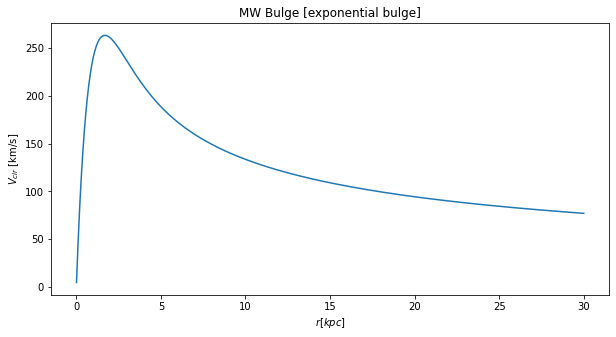

In [53]:
plt.figure(figsize=(10,5))
plt.plot(r,exp_bulge(r*1000,1.12,500))
plt.xlabel('$r [kpc]$')
plt.ylabel('$V_{cir}$ [km/s]')
plt.title('MW Bulge [exponential bulge]')

# Exponential Disk Profile

(Sofue 2013 eqn 33)

$$V^2_d(r) = 4\pi G\Sigma_{0}R_dy^2[I_0(y)K_0(y) - I_1(y)K_1(y)]$$

where $y = \frac{r}{2R_d}$

In [24]:
def disk_vel(r, SigD, Rd):
    '''
    :param SigD: Central surface density for the disk [M_sol/pc^2]
    :param Rd: The scale radius of the disk [pc]
    :r: The distance from the centre [pc]
    :return: The rotational velocity of the disk [km/s]
    '''
    # SigD, Rd = params

    y = r / (2 * Rd)

    bessel_component = (iv(0, y) * kn(0, y) - iv(1, y) * kn(1, y))
    vel2 = (4 * np.pi * G * SigD * y ** 2 * (Rd / (3.086e16)) * Msun) * bessel_component

    return np.sqrt(vel2) / 1000

In [25]:
Mdt = 2*np.pi*(8.44e2)*(3.5e3)**2
Mdt

64961852890.92974

Agrees with Sofue 2013, $M_d = 6.5 \times 10^{10} M_{\odot}$

Text(0.5, 1.0, 'MW Disk')

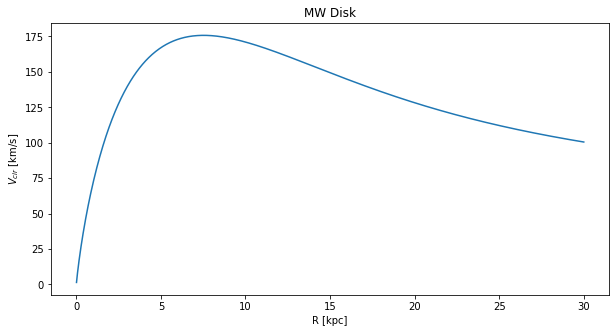

In [26]:
plt.figure(figsize=(10,5))
plt.plot(r, disk_vel(r*1000,8.44e2,3500))
plt.xlabel('R [kpc]')
plt.ylabel('$V_{cir}$ [km/s]')
plt.title('MW Disk')

The velocity curve is higher than what is presented in Sofue 2013 (Figure 20 [middle])

# Simplified Isothermal Halo Model

(Sofue 2013, eqn 51 & 52)

$$V_h = V_{\infty}\sqrt{1 - (\frac{R_h}{r}){tan}^{-1}(\frac{r}{R_h})}$$

where $V_{\infty} = \sqrt{4\pi G \rho_{0} R^2_h}$

In [27]:
v_inf = np.sqrt((4 * np.pi * G * 5.1e-3 * (Msun) * 12e3 ** 2) / (3.086e16))/1000 
v_inf

199.2433329270944

Sofue 2013 has $V_{\infty} = 200\text{km/s}$

In [28]:
def rho0_iso(Vinf, Rh):
    '''
    parameters:
    Vinf (rotational velocity): The rotational velocity when r approaches infinity (km/s)
    Rh (scale radius): The scale radius of the dark matter halo [pc]

    return: volume density of the isothermal halo (g/pc^3)
    '''
    return 0.740 * (Vinf / 200) **2 * (Rh/1000) ** (-2)


def rho_iso(r, Vinf, Rh):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    Vinf (rotational velocity): The rotational velocity when r approaches infinity (km/s)
    Rh (scale radius): The scale radius of the dark matter halo (pc)

    return: volume density of the isothermal halo (g/pc^3)
    '''
    rho_0 = rho0_iso(Vinf, Rh)
    return rho_0 / (1 + (r / Rh) ** 2)


def integrand_h_iso(r, Vinf, Rh):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    Vinf (rotational velocity): The rotational velocity when r approaches infinity (km/s)
    Rh (scale radius): The scale radius of the dark matter halo (pc)
    return: integrand for getting the mass of the isothermal halo
    '''

    return 4 * np.pi * (rho_iso(r, Vinf, Rh)) * r ** 2


def mass_h_iso(r, Vinf, Rh):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    e (rotational velocity): The rotational velocity when r approaches infinity (km/s)
    f (scale radius): The scale radius of the dark matter halo (pc)

    return: mass of the isothermal halo (g)
    '''
    halo_mass, m_err = inte.quad(integrand_h_iso, 0, r, args=(Vinf, Rh))
    return halo_mass


def vel_h_iso(r, Vinf, Rh):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    Vinf (rotational velocity): The rotational velocity when r approaches infinity (km/s)
    Rh (scale radius): The scale radius of the dark matter halo (pc)

    return: rotational velocity of the isothermal halo (pc/s)
    '''
    if isinstance(r, float):
        halo_mass = mass_h_iso(r, Vinf, Rh)
    else:
        halo_mass = np.zeros(len(r))
        for i in range(len(r)):
            halo_mass[i] = mass_h_iso(r[i], Vinf, Rh)

    vel2 = G * (halo_mass * Msun) / (r * 3.08E16)

    return np.sqrt(vel2)/1000

In [29]:
####################################################################################
def halo_vel_iso(r, rho0_h, Rh):
    '''
    :param r: The a distance from the centre (pc)
    :param rho_iso: The central density of the halo (M_sol/pc^3)
    :param Rh: The scale radius of the dark matter halo (pc)
    :return: rotational velocity
    '''
    v_inf = np.sqrt((4 * np.pi * G * rho0_h * (Msun) * Rh ** 2) / (3.086e16))/1000 #km/s
    if isinstance(r,float):
        # the part in the square root would be unitless
        vel = v_inf * np.sqrt(1 - ((Rh/r)*np.arctan2(r,Rh)))
    else:
        vel = np.zeros(len(r))
        for i in range(len(r)):
            vel[i] = v_inf * np.sqrt(1 - ((Rh/r[i])*np.arctan2(r[i],Rh)))
    return vel

#####################################################################################

Text(0.5, 1.0, 'MW Halo (Isothermal)')

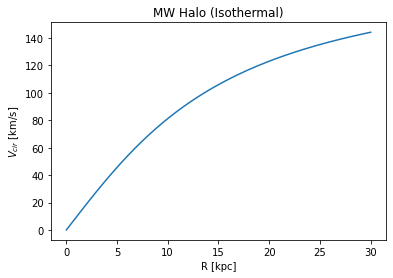

In [30]:
plt.plot(r,halo_vel_iso(r*1000,5.1e-3,12000),label='iso halo')
plt.xlabel('R [kpc]')
plt.ylabel('$V_{cir}$ [km/s]')
plt.title('MW Halo (Isothermal)')

# NFW Halo Model

(Sofue 2013, eqn 55, 54 & 57)

$$\rho_{NFW}(r) = \frac{\rho_{NFW}^{0}}{(r/R_h)(1+(r/R_h)^2)}$$

$$M_h(R) = 4\pi\int^{R}_0 \rho_{NFW}(r)r^2dr$$

$$V_h(R) = \sqrt{\frac{GM_h(R)}{R}}$$

In [31]:
def rho_NFW(r, rho0_h, Rh):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    rho0_h (central density): The central density of the halo (M_sol/pc^3)
    Rh (scale radius): The scale radius of the dark matter halo (pc)

    return: volume density of the isothermal halo (M/pc^3)
    '''
    return rho0_h / ((r / Rh) * ((1 + (r / Rh)) ** 2))


def integrand_h_NFW(r, rho0_h, Rh):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    rho0_h (central density): The central density of the halo (M_sol/pc^3)
    Rh (scale radius): The scale radius of the dark matter halo (pc)

    return: integrand for getting the mass of the isothermal halo
    '''

    return 4 * np.pi * (rho_NFW(r, rho0_h, Rh)) * r ** 2


def mass_h_NFW(r, rho0_h, Rh):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    rho0_h (central density): The central density of the halo (M_sol/pc^3)
    Rh (scale radius): The scale radius of the dark matter halo (pc)

    return: mass of the isothermal halo (g)
    '''
    halo_mass, m_err = inte.quad(integrand_h_NFW, 0, r, args=(rho0_h, Rh))
    return halo_mass


def vel_h_NFW(r, rho0_h, Rh):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    rho0_h (central density): The central density of the halo (M_sol/pc^3)
    Rh (scale radius): The scale radius of the dark matter halo (pc)

    return: rotational velocity of the NFW halo (pc/s)
    '''
    if isinstance(r, float):
        halo_mass = mass_h_NFW(r, rho0_h, Rh)
    else:
        halo_mass = np.zeros(len(r))
        for i in range(len(r)):
            halo_mass[i] = mass_h_NFW(r[i], rho0_h, Rh)

    vel2 = G * (halo_mass * Msun) / (r * 3.08E16)

    return np.sqrt(vel2)/1000

In [32]:
def halo_vel_NFW(r, rho0_h, Rh):
    if isinstance(r, float):
        halo_mass = 4*np.pi*rho0_h*Rh**3*((-r/(Rh+r)) + np.log(Rh + r) - np.log(Rh))
    else:
        halo_mass = np.zeros(len(r))
        for i in range(len(r)):
            halo_mass[i] = 4*np.pi*rho0_h*Rh**3*((-r[i]/(Rh+r[i])) + np.log(Rh + r[i]) - np.log(Rh))
    vel2 = G * (halo_mass * Msun) / (r * 3.086e16)
    return np.sqrt(vel2)/1000

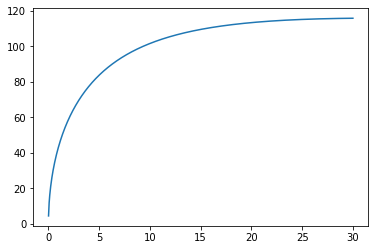

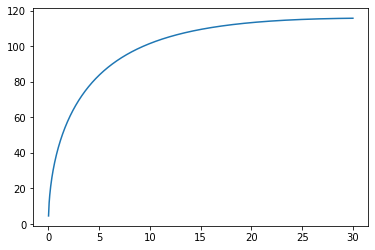

In [33]:
plt.plot(r,vel_h_NFW(r*1000,5.1e-3,15000),label='nfw halo')
plt.show()
plt.plot(r,halo_vel_NFW(r*1000,5.1e-3,15000),label='nfw halo')

Generated using the same parameter values as the Isothermal halo. We can see that the velocity is a lot lower than what is presented in Sofue 2013

# Burket Halo Model 

(Sofue 2013, eqn 56, 54, & 57)

$$\rho_{Bur}(r) = \frac{\rho_{Bur}^{0}}{(1+(r/R_h))(1+(r/R_h)^2)}$$

$$M_h(R) = 4\pi\int^{R}_0 \rho_{bur}(r)r^2dr$$

$$V_h(R) = \sqrt{\frac{GM_h(R)}{R}}$$

In [34]:
def rho_Burket(r, rho0_h, Rh):
    '''
    :param r: The distance from the centre (pc)
    :param rho0_h: The central density of the halo (M_sol/pc^3)
    :param Rh: The scale radius of the dark matter halo (pc)
    :return: volume density of the isothermal halo (M/pc^3)
    '''
    return (rho0_h) / ((1 + (r/Rh)) * (1 + (r/Rh) ** 2))


def integrand_h_Burket(r, rho0_h, Rh):
    '''
    :param r: The a distance from the centre (pc)
    :param rho0_h: The central density of the halo (M_sol/pc^3)
    :param Rh: The scale radius of the dark matter halo (pc)
    :return: integrand for getting the mass of the isothermal halo
    '''
    return 4 * np.pi * (rho_Burket(r, rho0_h, Rh)) * r ** 2


def mass_h_Burket(r, rho0_h, Rh):
    '''
    :param r: The a distance from the centre (pc)
    :param rho0_h: The central density of the halo (M_sol/pc^3)
    :param Rh: The scale radius of the dark matter halo (pc)
    :return: mass of the isothermal halo (g)
    '''
    halo_mass, m_err = inte.quad(integrand_h_Burket, 0, r, args=(rho0_h, Rh))
    return halo_mass


def vel_h_Burket(r, rho0_h, Rh):
    '''
    r (radius): The a distance from the centre [pc]
    rho0_h (central density): The central density of the halo [M_sol/pc^3]
    Rh (scale radius): The scale radius of the dark matter halo [pc]
    :return: rotational velocity of the Burket halo [km/s]
    '''
    if isinstance(r, float):
        halo_mass = mass_h_Burket(r, rho0_h, Rh)
    else:
        halo_mass = np.zeros(len(r))
        for i in range(len(r)):
            halo_mass[i] = mass_h_Burket(r[i], rho0_h, Rh)

    vel2 = G * (halo_mass * Msun) / (r * 3.08E16)

    return np.sqrt(vel2)/1000

In [35]:
def halo_vel_bur(r,rho0_h, Rh):
    if isinstance(r, float):
        halo_mass = np.pi * (-rho0_h) * (Rh**3) * (-np.log(Rh**2 + r**2) - 2*np.log(Rh + r) + 2*np.arctan2(r, Rh) + np.log(Rh**2)\
                                               + 2*np.log(Rh) - 2*np.arctan2(0, Rh))
    else:
        halo_mass = np.zeros(len(r))
        for i in range(len(r)):
            halo_mass[i] = np.pi * (-rho0_h) * (Rh**3) * (-np.log(Rh**2 + r[i]**2) - 2*np.log(Rh + r[i]) + 2*np.arctan2(r[i], Rh) + np.log(Rh**2)\
                                               + 2*np.log(Rh) - 2*np.arctan2(0, Rh))
    vel2 = G * (halo_mass * Msun) / (r * 3.086e16)
    return np.sqrt(vel2)/1000

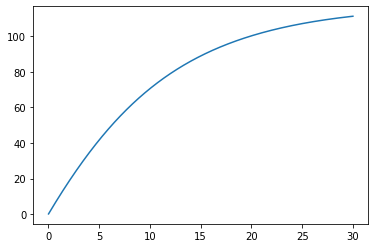

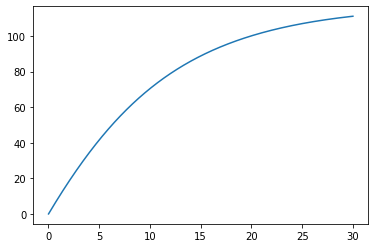

In [36]:
plt.plot(r,vel_h_Burket(r*1000,5.1e-3,15000),label='bur halo')
plt.show()
plt.plot(r,halo_vel_bur(r*1000,5.1e-3,15000),label='bur halo')

Generated using the same parameter values as the Isothermal halo. We can see that the velocity is a lot lower than what is presented in Sofue 2013

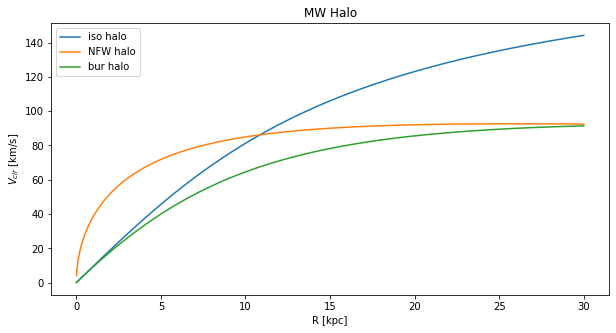

In [37]:
plt.figure(figsize=(10,5))
plt.plot(r,halo_vel_iso(r*1000,5.1e-3,12000),label='iso halo')
plt.plot(r,halo_vel_NFW(r*1000,5.1e-3,12000),label='NFW halo')
plt.plot(r,halo_vel_bur(r*1000,5.1e-3,12000),label='bur halo')
plt.xlabel('R [kpc]')
plt.ylabel('$V_{cir}$ [km/s]')
plt.title('MW Halo')
plt.legend()

# Putting everything together

In [57]:


def vel_tot_iso(r, params):
    log_rhob0,Rb, SigD, Rd, rho0_h, Rh = params

    r_pc = r * 1000
    Rb_pc = Rb * 1000
    Rd_pc = Rd * 1000
    Rh_pc = Rh * 1000

    Vbulge = exp_bulge(r_pc,log_rhob0,Rb_pc)
    Vdisk = disk_vel(r_pc, SigD, Rd_pc)
    Vhalo = halo_vel_iso(r_pc, rho0_h, Rh_pc)
    v2 = Vbulge ** 2 + Vdisk ** 2 + Vhalo ** 2

    return np.sqrt(v2)

#------------------------------------------------------------------------------------
# NFW
def vel_tot_NFW(r, params):
    A, Vin, SigD, Rd, rho0_h, Rh = params

    r_pc = r * 1000
    
    Rd_pc = Rd * 1000
    Rh_pc = Rh * 1000

    Vbulge = bulge_vel_mod(r_pc, A, Vin, Rd_pc)
    Vdisk = disk_vel(r_pc, SigD, Rd_pc)
    Vhalo = halo_vel_NFW(r_pc, rho0_h, Rh_pc)
    v2 = Vbulge ** 2 + Vdisk ** 2 + Vhalo ** 2

    return np.sqrt(v2)
#------------------------------------------------------------------------------------
# Burket
def vel_tot_bur(r, params):
    A, Vin, SigD, Rd, rho0_h, Rh = params

    r_pc = r * 1000
    Rd_pc = Rd * 1000
    Rh_pc = Rh * 1000

    Vbulge = bulge_vel_mod(r_pc, A, Vin, Rd_pc)
    Vdisk = disk_vel(r_pc, SigD, Rd_pc)
    Vhalo = halo_vel_bur(r_pc, rho0_h, Rh_pc)
    v2 = Vbulge ** 2 + Vdisk ** 2 + Vhalo ** 2

    return np.sqrt(v2)

In [58]:
plt.plot(r,bulge_vel_mod(r*1000,1,270,3500),'--',label='bulge')
plt.plot(r, disk_vel(r*1000,8.44e2,3500),':',label='disk')
plt.plot(r,vel_h_iso(r*1000,200,5500),label='iso halo')
plt.plot(r,vel_tot_iso(r,[1,270,8.44e2,3.5,200,5.5]),label='iso tot')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('r [kpc]')
plt.ylabel('$v_{cir}$ [km/s]')
plt.title('Recreating Rotation curve of the Milky Way')

NameError: name 'bulge_vel_mod' is not defined

In [59]:
plt.plot(r,bulge_vel_mod(r*1000,1,270,3500),'--',label='bulge')
plt.plot(r, disk_vel(r*1000,8.44e2,3500),':',label='disk')
plt.plot(r,halo_vel_iso(r*1000,5.1e-3,12000),label='iso halo')
plt.plot(r,vel_tot_iso_alt(r,[1,270,8.44e2,3.5,5.1e-3,12]),label='iso tot')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('r [kpc]')
plt.ylabel('$v_{cir}$ [km/s]')
plt.title('Recreating Rotation curve of the Milky Way')

NameError: name 'bulge_vel_mod' is not defined

# Values of the parameters

$$\alpha_b = 1$$
$$V_{in} = 250 \text{km/s}$$
$$\Sigma_{dc} = 8.44\times10^2 M_{\odot}/{pc}^2$$
$$R_d = 3.5 \text{kpc}$$
$$\rho_{hc} = 5.1 \times 10^{-3} M_{\odot}/{pc}^3$$
$$R_h = 12 \text{kpc}$$

In [60]:
plt.plot(r,bulge_vel_mod(r*1000,1,270,3500),'--',label='bulge')
plt.plot(r, disk_vel(r*1000,8.44e2,3500),':',label='disk')
plt.plot(r,vel_h_iso(r*1000,200,5500),label='iso halo')
plt.plot(r,vel_h_NFW(r*1000,3e-2,5500),label='nfw halo')
plt.plot(r,halo_vel_bur(r*1000,3e-2,5500),label='bur halo')
plt.plot(r,vel_tot_iso(r,[1,250,8.44e2,3.5,200,5.5]),label='iso tot')
plt.plot(r,vel_tot_NFW(r,[1,250,8.44e2,3.5,5.1e-3,12]),label='new tot')
plt.plot(r,vel_tot_bur(r,[1,250,8.44e2,3.5,5.1e-3,12]),label='bur tot')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('r [kpc]')
plt.ylabel('$v_{cir}$ [km/s]')
plt.title('Recreating Rotation curve of the Milky Way')

NameError: name 'bulge_vel_mod' is not defined

In [61]:
plt.plot(r,bulge_vel_mod(r*1000,1,270,3500),'--',label='bulge')
plt.plot(r, disk_vel(r*1000,8.44e2,3500),':',label='disk')
plt.plot(r,halo_vel_iso(r*1000,5.1e-3,12000),label='iso halo')
#plt.plot(r,halo_vel_NFW(r*1000,5.1e-3,12000),label='nfw halo')
#plt.plot(r,halo_vel_bur(r*1000,5.1e-3,12000),label='bur halo')
plt.plot(r,vel_tot_iso(r,[1,270,8.44e2,3.5,200,5.5]),label='iso tot')
#plt.plot(r,vel_tot_NFW(r,[1,250,8.44e2,3.5,5.1e-3,12]),label='new tot')
#plt.plot(r,vel_tot_bur(r,[1,250,8.44e2,3.5,5.1e-3,12]),label='bur tot')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('r [kpc]')
plt.ylabel('$v_{cir}$ [km/s]')
plt.xlim(0,20)
plt.title('Recreating MW RC')

NameError: name 'bulge_vel_mod' is not defined

This matches Sofue 2013, Fig. 6

# Now Using slightly different parameter values 
(Obtained by tweaking)

$$\alpha_b = 1$$
$$V_{in} = 250 \text{km/s}$$
$$\Sigma_{dc} = 8.44\times10^2 M_{\odot}/{pc}^2$$
$$R_d = 3.5 \text{kpc}$$
$$\rho_{hc, iso} = 7 \times 10^{-3} M_{\odot}/{pc}^3$$
$$R_{hc, iso} = 16 \text{kpc}$$
$$\rho_{hc, NFW} = 8 \times 10^{-3} M_{\odot}/{pc}^3$$
$$R_{hc, NFW} = 16 \text{kpc}$$
$$\rho_{hc, bur} = 1.2 \times 10^{-2} M_{\odot}/{pc}^3$$
$$R_{hc,bur} = 16 \text{kpc}$$

In [62]:
plt.plot(r,bulge_vel_mod(r*1000,1,270,3500),'--',label='bulge')
plt.plot(r, disk_vel(r*1000,8.44e2,3500),':',label='disk')
plt.plot(r,halo_vel_iso(r*1000,7e-3,16000),label='iso halo')
plt.plot(r,halo_vel_NFW(r*1000,8e-3,16000),label='nfw halo')
plt.plot(r,halo_vel_bur(r*1000,1.2e-2,16000),label='bur halo')
plt.plot(r,vel_tot_iso(r,[1,250,8.44e2,3.5,7e-3,16]),label='iso tot')
plt.plot(r,vel_tot_NFW(r,[1,250,8.44e2,3.5,8e-3,16]),label='new tot')
plt.plot(r,vel_tot_bur(r,[1,250,8.44e2,3.5,1.2e-2,16]),label='bur tot')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('r [kpc]')
plt.ylabel('$v_{cir}$ [km/s]')
plt.title('Rotation curve of the Milky Way')

NameError: name 'bulge_vel_mod' is not defined

$$\rho_{iso} (R) = \frac{\rho_{iso}^{0}}{1+(R/r_h)^2}$$
$$\rho_{iso}^{0} = 0.74(\frac{V_{\infty}}{200km/s})(\frac{h}{1 kpc})^{-2} M_{\odot}pc^{-3}$$
$$M(R) = 4\pi\int^{R}_0 \rho_{iso}(R)R^2dR$$

In [63]:
0.740 * (200 / 200) **2 * (5500/1000) ** (-2)

0.02446280991735537

In [64]:
v_inf = np.sqrt((4 * np.pi * G * 5.1e-3* (Msun) * 12000 ** 2) / (3.086e16))/1000
v_inf

199.2433329270944

Text(0.5, 1.0, 'Recreating Rotation curve of the Milky Way')

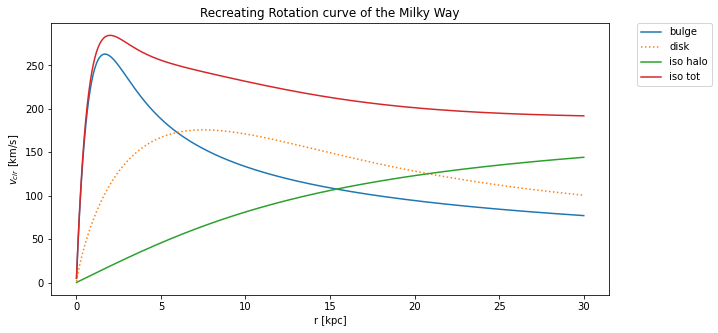

In [67]:

plt.figure(figsize=(10,5))
plt.plot(r,exp_bulge(r*1000,1.12,500),label='bulge')
plt.plot(r, disk_vel(r*1000,8.44e2,3500),':',label='disk')
plt.plot(r,halo_vel_iso(r*1000,5.1e-3,12000),label='iso halo')
plt.plot(r,vel_tot_iso(r,[1.12,.5,8.44e2,3.5,5.1e-3,12]),label='iso tot')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('r [kpc]')
plt.ylabel('$v_{cir}$ [km/s]')
plt.title('Recreating Rotation curve of the Milky Way')
